In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [3]:
(ds_train, ds_test_), ds_info = tfds.load('celeb_a',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True)

In [4]:
batch_size = 128

In [5]:
def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [112, 112])
    image = tf.cast(image, tf.float32)/255.
    return image, image

In [6]:
ds_train = ds_train.map(preprocess).shuffle(batch_size).batch(batch_size).prefetch(batch_size)
ds_test = ds_test_.map(preprocess).batch(batch_size).prefetch(batch_size)

In [7]:
train_num = ds_info.splits['train'].num_examples
test_num = ds_info.splits['test'].num_examples

In [8]:
class GaussianSampling(Layer):
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon
        
        return samples

In [9]:
class DownConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f'DownConvBlock_{DownConvBlock.count}')
        DownConvBlock.count += 1
        self.forward = Sequential([Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(BatchNormalization())
        self.forward.add(layers.LeakyReLU(0.2))
        
    def call(self, inputs):
        return self.forward(inputs)

In [10]:
class UpConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), padding='same'):
        super(UpConvBlock, self).__init__(name=f'UpConvBlock_{UpConvBlock.count}')
        UpConvBlock.count += 1
        self.forward = Sequential([Conv2D(filters, kernel_size, 1, padding)])
        self.forward.add(layers.LeakyReLU(0.2))
        self.forward.add(UpSampling2D((2,2)))
        
    def call(self, inputs):
        return self.forward(inputs)

In [11]:
class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        
        self.features_extract = Sequential([
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            Flatten()])
        
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
        
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

In [12]:
class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
        
        self.forward = Sequential([
            Dense(7*7*64, activation='relu'),
            Reshape((7,7,64)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')
        ])
        
    def call(self, inputs):
        return self.forward(inputs)


In [13]:
class VAE(Model):
    def __init__(self, z_dim, name='vae'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)
        return out

In [14]:
vae = VAE(z_dim=200)

In [15]:
def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * tf.reduce_mean(1+vae.logvar -tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss

In [16]:
def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

In [17]:
def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.01
    return kl_weight_const*kl_loss + rc_loss

In [18]:
model_path = 'vae_celeb_a.h5'
checkpoint = ModelCheckpoint(model_path,
                             monitor='vae_rc_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_weights_only = True)

early = EarlyStopping(monitor='vae_rc_loss',
                      mode='auto',
                      patience=3)

callbacks_list = [checkpoint, early]

In [19]:
initial_learning_rate = 1e-3
steps_per_epoch = int(np.round(train_num/batch_size))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True)

In [20]:
vae.compile(loss=[vae_loss],
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-3),
            metrics =[vae_kl_loss, vae_rc_loss])

In [21]:
history = vae.fit(ds_train, validation_data=ds_test,
                  epochs=20, callbacks=callbacks_list)

Epoch 1/20
1272/1272 [==============================] - ETA: 0s - loss: 0.4867 - vae_kl_loss: 44.7189 - vae_rc_loss: 0.0394
Epoch 1: vae_rc_loss improved from inf to 0.03936, saving model to vae_celeb_a.h5
1272/1272 [==============================] - 72s 49ms/step - loss: 0.4867 - vae_kl_loss: 44.7189 - vae_rc_loss: 0.0394 - val_loss: 0.0218 - val_vae_kl_loss: 0.5368 - val_vae_rc_loss: 0.0165
Epoch 2/20
1271/1272 [============================>.] - ETA: 0s - loss: 0.0216 - vae_kl_loss: 0.4345 - vae_rc_loss: 0.0173
Epoch 2: vae_rc_loss improved from 0.03936 to 0.01730, saving model to vae_celeb_a.h5
1272/1272 [==============================] - 63s 49ms/step - loss: 0.0216 - vae_kl_loss: 0.4345 - vae_rc_loss: 0.0173 - val_loss: 0.0211 - val_vae_kl_loss: 0.4575 - val_vae_rc_loss: 0.0165
Epoch 3/20
1272/1272 [==============================] - ETA: 0s - loss: 0.0195 - vae_kl_loss: 0.4393 - vae_rc_loss: 0.0151
Epoch 3: vae_rc_loss improved from 0.01730 to 0.01508, saving model to vae_celeb_a.

In [22]:
images, labels = next(iter(ds_train))
vae.load_weights(model_path)
outputs = vae.predict(images)

4/4 [==============================] - 0s 5ms/step


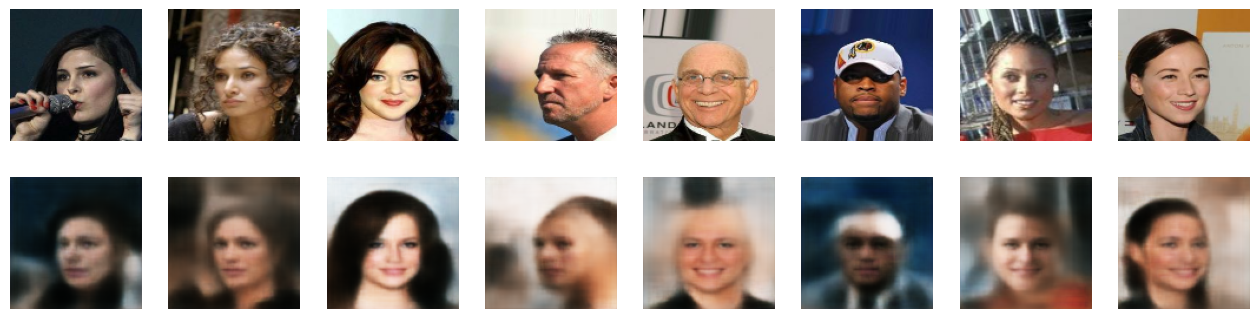

In [23]:
grid_col = 8
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))

i = 0

for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i])
        axarr[row, col].axis('off')
        axarr[row+1, col].imshow(outputs[i])
        axarr[row+1, col].axis('off')
        i+=1
plt.show()

In [24]:
avg_z_mean = []
avg_z_std = []
for i in range(steps_per_epoch):
    images, labels = next(iter(ds_train))
    z, z_mean, z_logvar = vae.encoder(images)
    avg_z_mean.append(np.mean(z_mean, axis=0))
    avg_z_std.append(np.mean(np.exp(0.5*z_logvar), axis=0))
                     
avg_z_mean = np.mean(avg_z_mean, axis=0)
avg_z_std = np.mean(avg_z_std, axis=0)

Text(0.5, 0, 'z dimension')

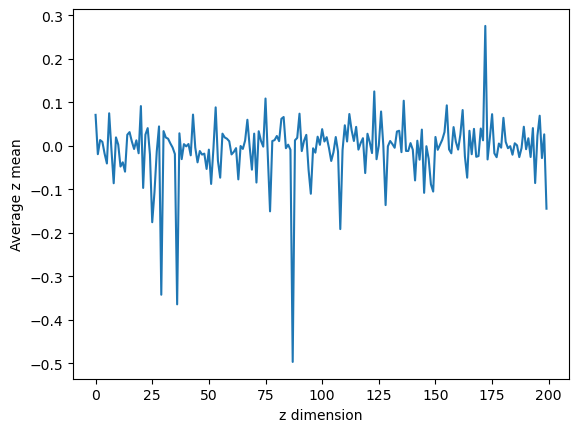

In [25]:
plt.plot(avg_z_mean)
plt.ylabel('Average z mean')
plt.xlabel('z dimension')

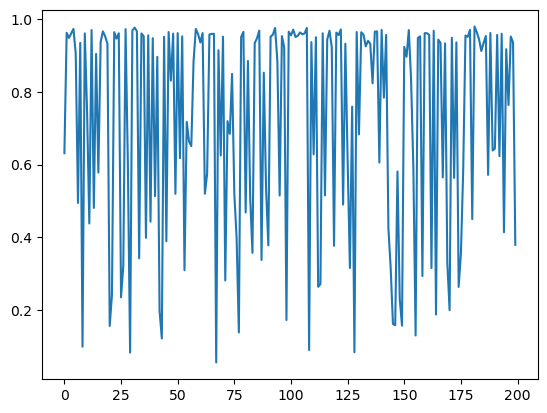

In [26]:
plt.plot(avg_z_std)

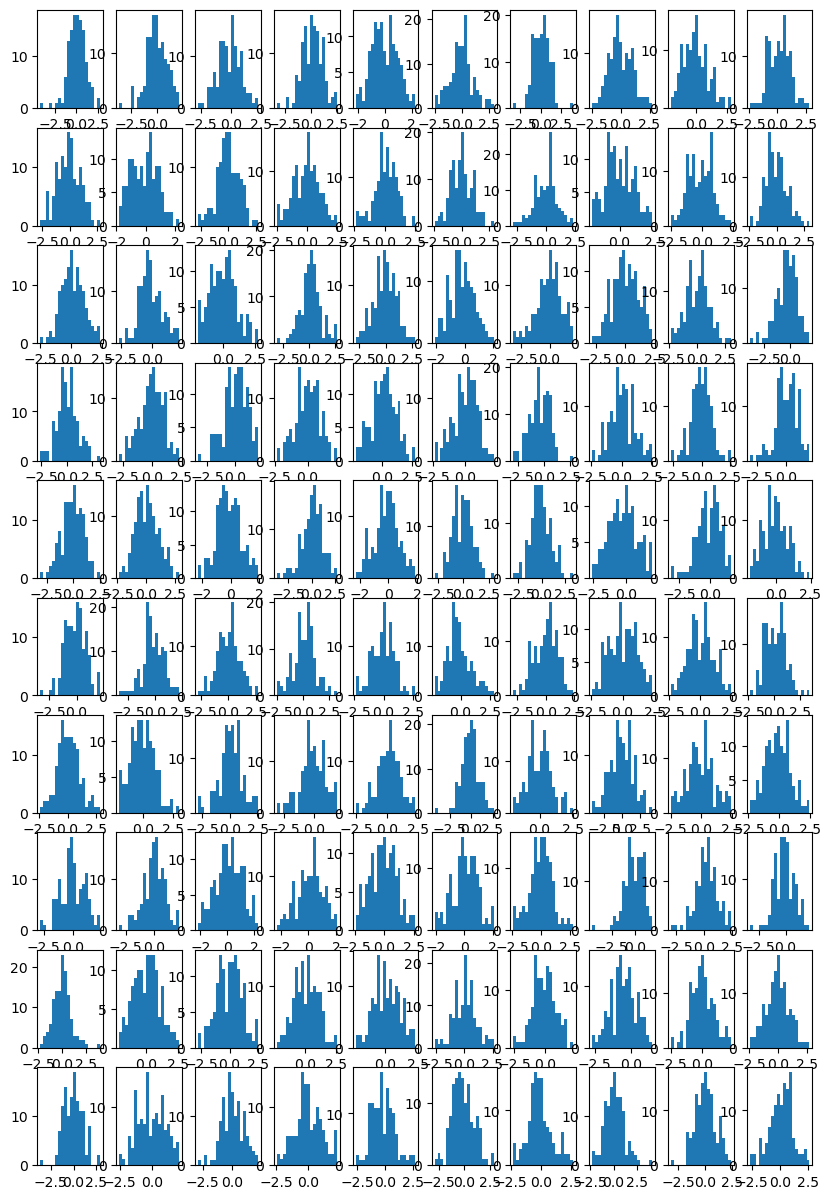

In [28]:
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, 1.5*grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row, col].hist(z[:,i], bins=20)
        i += 1
        
plt.show()

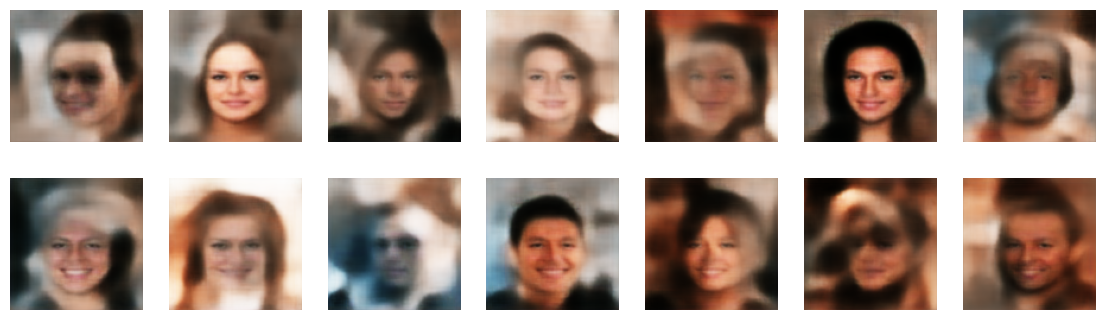

In [29]:
z_dim = 200
z_samples = np.random.normal(loc=0, scale=1, size=(25, z_dim))
images = vae.decoder(z_samples.astype(np.float32))
grid_col = 7
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

i=0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        i+=1
plt.show()

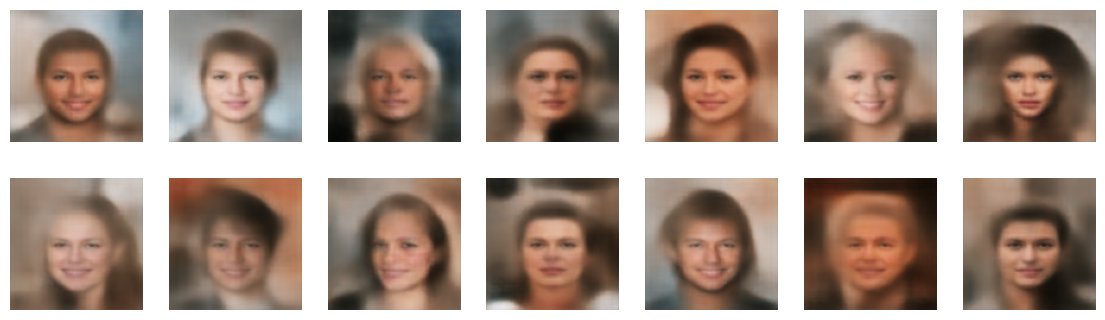

In [30]:
z_samples = np.random.normal(loc=0, scale=np.mean(avg_z_std), size=(25, z_dim))
z_samples += avg_z_mean

images = vae.decoder(z_samples.astype(np.float32))
grid_col = 7
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

i=0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i])
        axarr[row, col].axis('off')
        i+=1
plt.show()

In [31]:
(ds_train, ds_test), ds_info = tfds.load('celeb_a',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
test_num = ds_info.splits['test'].num_examples

In [32]:
def preprocess_attrib(sample, attribute):
    image = sample['image']
    image = tf.image.resize(image, [112, 112])
    image = tf.cast(image, tf.float32)/255.
    return image, sample['attributes'][attribute]

In [33]:
attribute =  'Smiling'

In [36]:
def extract_attrib_vector(attribute, ds):
    batch_size = 128
    ds = ds.map(lambda x: preprocess_attrib(x, attribute))
    ds = ds.batch(batch_size)
    
    steps_per_epoch = int(np.round(test_num/batch_size))
    
    pos_z = []
    pos_z_num = []
    neg_z = []
    neg_z_num = []
    
    for i in range(steps_per_epoch):
        images, labels = next(iter(ds))
        z, z_mean, z_logvar = vae.encoder(images)
        z = z.numpy()
        step_pos_z = z[labels==True]
        pos_z.append(np.mean(step_pos_z, axis=0))
        pos_z_num.append(step_pos_z.shape[0])
        
        step_neg_z = z[labels==True]
        neg_z.append(np.mean(step_neg_z, axis=0))
        neg_z_num.append(step_neg_z.shape[0])
    avg_pos_z = np.average(pos_z, axis=(0), weights=pos_z_num)
    avg_neg_z = np.average(neg_z, axis=(0), weights=neg_z_num)
    attrib_vector = avg_pos_z - avg_neg_z
    return attrib_vector

In [37]:
attributes = list(ds_info.features['attributes'].keys())
attrib_vectors = {}

for attrib in attributes:
    print(attrib)
    attrib_vectors[attrib] = extract_attrib_vector(attrib, ds_test)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin


C:\Users\admin\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [46]:
def explore_latent_variable(image, attrib):
    grid_col = 8
    grid_row = 1
    
    z_samples, _, _ = vae.encoder(tf.expand_dims(image, 0))
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))
    i = 0
    row = 0
    step = -3
    axarr[0].imshow(image)
    axarr[0].axis('off')
    for col in range(1, grid_col):
        new_z_samples = z_samples + step*attrib_vectors[attrib]
        reconstructed_image = vae.decoder(new_z_samples)
        
        step += 1
        axarr[col].imshow(reconstructed_image[0])
        axarr[col].axis('off')
        i+=1
    plt.show()

In [47]:
ds_test1 = ds_test.map(preprocess).batch(100)

In [48]:
images, labels = next(iter(ds_test1))

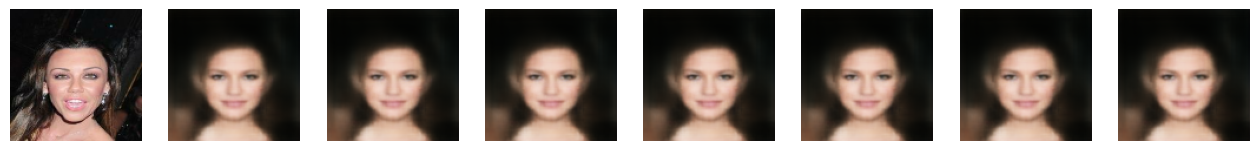

In [49]:
explore_latent_variable(images[31], 'Male')

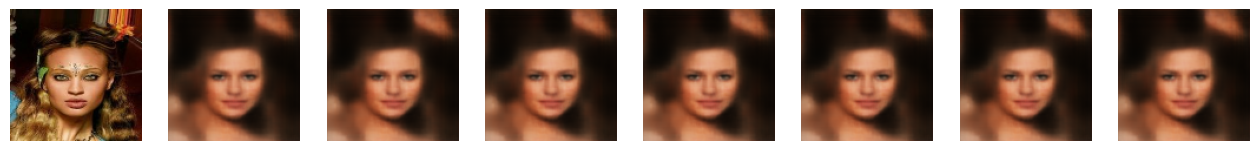

In [50]:
explore_latent_variable(images[29], 'Eyeglasses')

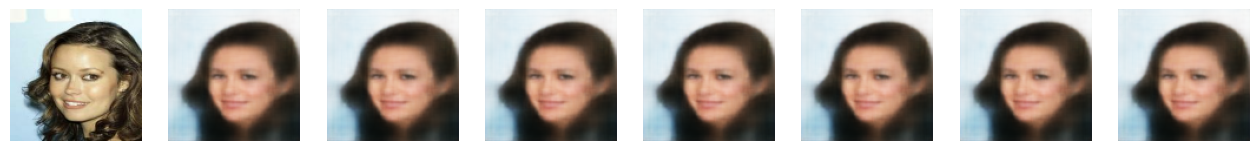

In [51]:
explore_latent_variable(images[10], "Chubby")

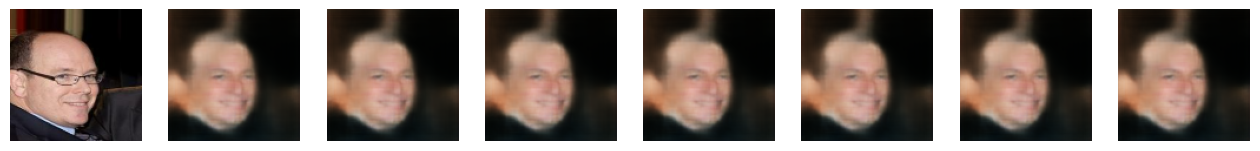

In [52]:
explore_latent_variable(images[7], "Mustache")

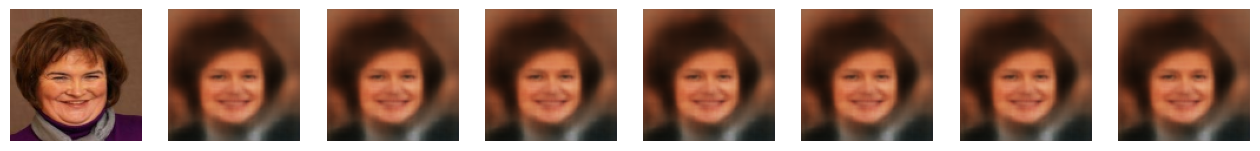

In [53]:
explore_latent_variable(images[6], "Young")

In [54]:
z_samples = np.random.normal(loc=0, scale=np.mean(avg_z_std), size=(1,200))
z_samples += avg_z_mean

In [55]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [56]:
@interact
def explore_latent_variable(Male=(-5,5,0.1),
                            Eyeglasses = (-5,5,0.1),
                            Young = (-5,5,0.1),
                            Smiling = (-5,5,0.1),
                            Blond_Hair = (-5,5,0.1),
                            Pale_Skin = (-5,5,0.1),
                            Mustache = (-5,5,0.1)):
    new_z_samples = z_samples + \
                    Male*attrib_vectors['Male'] + \
                    Eyeglasses*attrib_vectors['Eyeglasses'] +\
                    Young*attrib_vectors['Young'] +\
                    Smiling*attrib_vectors['Smiling']+\
                    Blond_Hair*attrib_vectors['Blond_Hair'] +\
                    Pale_Skin*attrib_vectors['Pale_Skin'] +\
                    Mustache*attrib_vectors['Mustache']
    images = vae.decoder(new_z_samples.astype(np.float32))
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(images[0])

interactive(children=(FloatSlider(value=0.0, description='Male', max=5.0, min=-5.0), FloatSlider(value=0.0, de…